In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from plotly.offline import plot
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_rand_score

from utils import save_plotly_figure_as_html
from ex_01_read_data import get_welding_data
from ex_03_feature_extraction import extract_features
from ex_04_my_kmeans import MyKMeans


In [20]:
data_path = Path("data/Welding/data.csv")
plot_path = Path("plots/ex_04")
plot_path.mkdir(parents=True, exist_ok=True)


data, labels, exp_ids = get_welding_data(data_path, n_samples=5_000)

## Exercise 4.2: Optimal Cluster Selection

Implement the elbow method to find the optimal number of clusters for the raw time series data using your implement of the kmeans algorithm (MyKMeans).

1. Calculate the distortion (inertia) for different values of k (1 to 10)
2. Plot the results to identify the "elbow point" with matplotlib where adding more clusters produces diminishing returns
3. This will help determine the most appropriate number of clusters for our welding data

Training:  48%|████▊     | 24/50 [00:01<00:01, 19.01it/s]


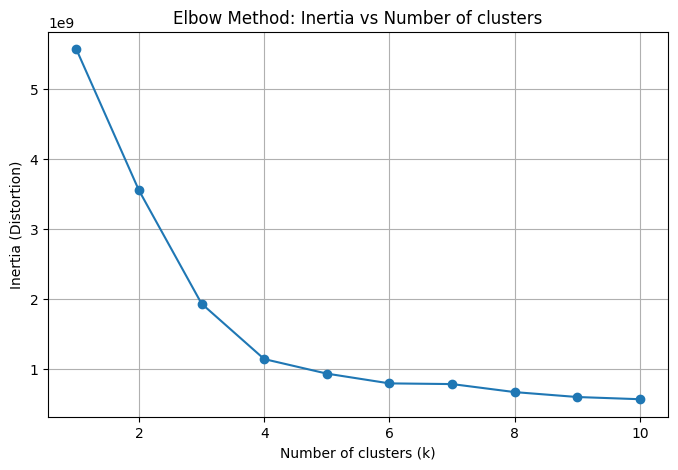

In [21]:
def elbow_method(X, max_clusters=10, distance_metric="euclidean"):
    """
    Apply the elbow method to find the optimal number of clusters.
    
    Args:
        X: Feature matrix (scaled)
        max_clusters: Maximum number of clusters to try
        distance_metric: Distance metric to use
    """
    inertias = []
    K_range = range(1, 11)

    for k in K_range:
        kmeans = MyKMeans(k=k, max_iter=50, distance_metric="euclidean")  # or "dtw" later
        kmeans.fit(X)  # shape: (n_samples, seq_len, features)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8,5))
    plt.plot(K_range, inertias, marker='o')
    plt.title("Elbow Method: Inertia vs Number of clusters")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Distortion)")
    plt.grid(True)
    plt.show()
    pass

elbow_method(data)

## Exercise 4.3: Clustering with MyKMeans

### Based on the elbow curve above, explain your choice of k:

1. What does the shape of the elbow curve tell you about the underlying data structure?
2. Why did you select this specific number of clusters?
   - Consider the plot and the elbow method to justify your choice
   - How might this choice affect the interpretability of the resulting clusters?

### KMeans with euclidean distance and dtw distance
1. run K means with you selected k 


The clearer the elbow in the graph, the clearer the clustering in the data. If there is no clear elbow, the data might be too homogenous.

The elbow method helps to determine good choices for k, since it's relatively easy to tell at what point adding more clusters yields diminishing returns in reducing inertia. In the above graph the strongest curve is either at `k = 4`.


In [22]:
k_opt = 4 

# Euclidean
kmeans_euc = MyKMeans(k=k_opt, max_iter=100, distance_metric="euclidean")
kmeans_euc.fit(data)
labels_euc = kmeans_euc.predict(data)

# DTW
kmeans_dtw = MyKMeans(k=k_opt, max_iter=100, distance_metric="dtw")
kmeans_dtw.fit(data)
labels_dtw = kmeans_dtw.predict(data)

Training:  17%|█▋        | 17/100 [01:58<09:36,  6.95s/it]


## Exercise 4.4: Cluster Visualization

Plot the mean time series (centroids) for each cluster to visualize and understand the patterns.

Remember that our welding data has both current and voltage measurements over time (shape: n_samples, sequence_length, features). For each cluster:
1. Plot the average current pattern
2. Plot the average voltage pattern
3. Look for distinctive characteristics in each cluster that might relate to welding quality

This visualization will help identify what makes each cluster unique in terms of temporal patterns.

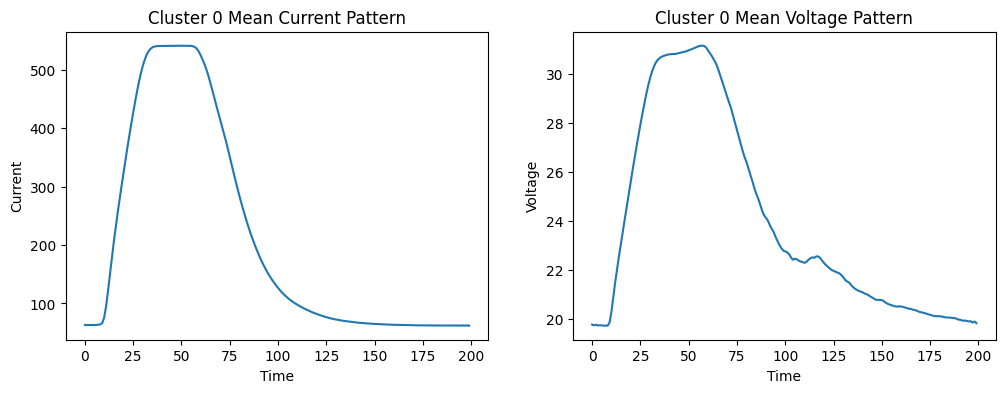

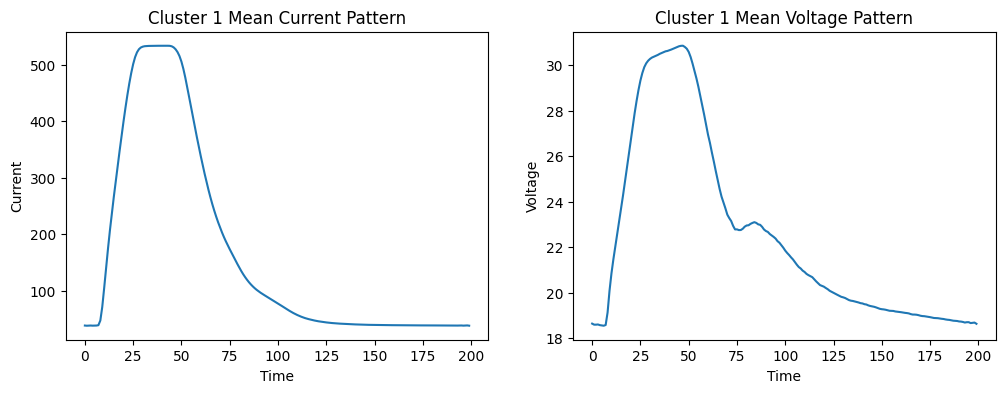

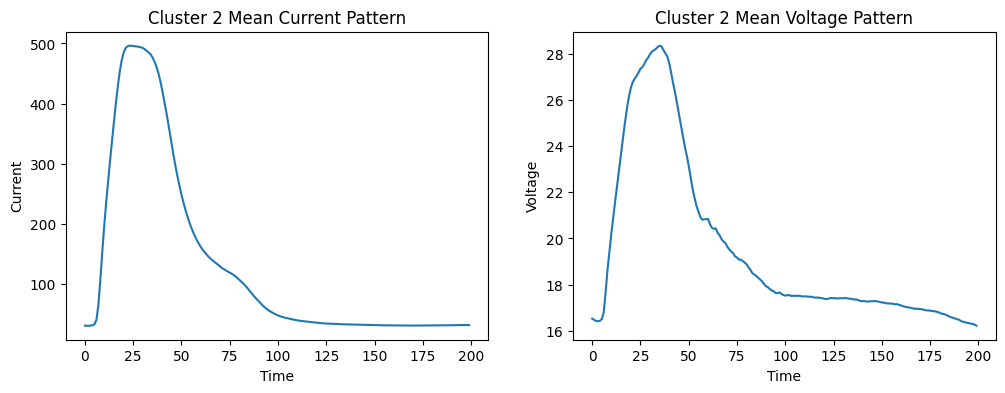

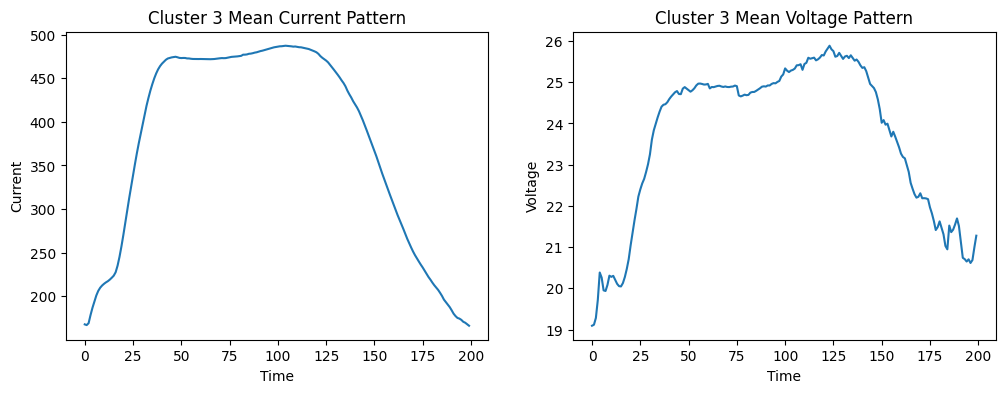

In [23]:
def plot_cluster_means(data, labels, n_clusters):
    for cluster_id in range(n_clusters):
        cluster_data = data[labels == cluster_id]
        mean_ts = np.mean(cluster_data, axis=0)  # shape: (seq_len, features)
        
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(mean_ts[:, 0])
        plt.title(f"Cluster {cluster_id} Mean Current Pattern")
        plt.xlabel("Time")
        plt.ylabel("Current")
        
        plt.subplot(1,2,2)
        plt.plot(mean_ts[:, 1])
        plt.title(f"Cluster {cluster_id} Mean Voltage Pattern")
        plt.xlabel("Time")
        plt.ylabel("Voltage")
        
        plt.show()

plot_cluster_means(data, labels_euc, k_opt)

The voltage bumps in cluster 0 at 110(time), cluster 1 at 75(time), cluster 3 at 180(time) are indicators on bad welding quality.  
In cluster 2 the voltage doesn't rise as quickly as expected.

## Exercise 4.5: Feature-Based Clustering

Now we'll use the engineered features extracted in Exercise 3 instead of raw time series data. Therefore, you can use the euclidean distance metric.

1. Load your extracted features from exercise 3 
2. Split them into data and labels
3. Scale the data for better clustering performance
4. Apply the elbow method again to determine the optimal number of clusters for the feature-based approach
5. Compare this result with the clustering of raw time series data. Consider why the optimal k might differ between the two approaches:
   - Do engineered features represent the data differently?
   - Which approach might better capture the relevant patterns for quality assessment?


Training:  10%|█         | 10/100 [00:00<00:00, 249.28it/s]


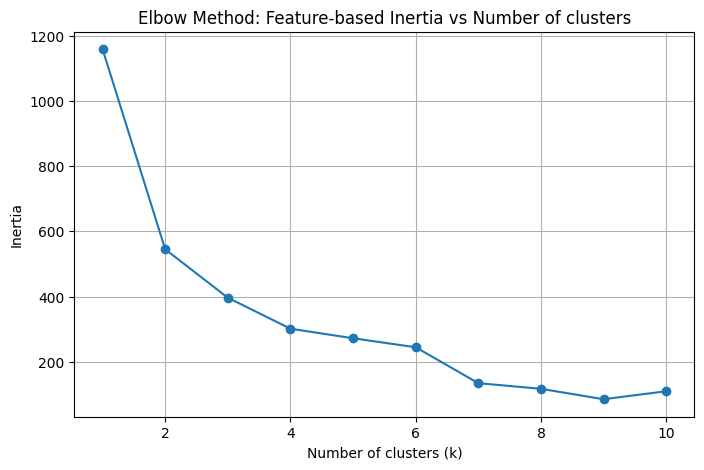

In [24]:
# Extract features from the data
features = extract_features(data, labels)

# Features
labels_feat = features["label"]
features.drop(columns=["label"], inplace=True)

# Scale the features for clustering
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Run elbow method on scaled features
inertias_feat = []
K_range = range(1, 11)
for k in K_range:
    kmeans_feat = MyKMeans(k=k, max_iter=100, distance_metric="euclidean")
    kmeans_feat.fit(features_scaled)
    inertias_feat.append(kmeans_feat.inertia_)

# Plot inertia vs k
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias_feat, marker='o')
plt.title("Elbow Method: Feature-based Inertia vs Number of clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

5. Compare this result with the clustering of raw time series data. Consider why the optimal k might differ between the two approaches:
   - Do engineered features represent the data differently?  
   Yes, the noise is heavily reduced, there are smaller dimensions and the clustering is more compact. And obviously features are summarizations of otherwise time-dependent data.
   - Which approach might better capture the relevant patterns for quality assessment?  
   If we are not looking for subtle defects and only care about interpretable, realistic data, then the engineered features might be better suited.
For features I would use `k = 2` or `k = 7`.

## Exercise 4.6: Advanced 3D Visualization

Visualize the clustering results using interactive 3D plots with Plotly.

1. Use PCA to reduce the dimensionality of our feature space to 3 components
2. Create two visualizations:
   - Points colored by assigned cluster
   - Same points colored by actual quality labels
3. Include the explained variance for each principal component in the axis labels
4. Save the figures to the plot_path


This visualization will help us understand how well our clustering approach aligns with the known quality designations.

#### Note:
- You can use the following links to find more information about the PCA:
   - https://en.wikipedia.org/wiki/Principal_component_analysis
   - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


In [28]:
#fig1_save_path = save_plotly_figure_as_html(fig1, output_dir / f'clusters_3d_{n_clusters}_clusters')
#fig2_save_path = save_plotly_figure_as_html(fig2, output_dir / f'quality_3d_{n_clusters}_clusters')

n_clusters = 7

def visualize_clustering_3d(
    x: np.ndarray,
    predicted_labels: np.ndarray,
    true_labels: np.ndarray,
    plot_path: str
):
    """
    Visualize clustering results using PCA-reduced 3D Plotly plots.

    Args:
        x (np.ndarray): Input data of shape (n_samples, n_features).
        predicted_labels (np.ndarray): Cluster labels predicted by KMeans.
        true_labels (np.ndarray): Ground truth quality labels.
        plot_path (str): Directory to save the generated plots.
    """

    # Apply PCA to reduce to k_opt components
    pca = PCA(n_components=n_clusters)
    x_pca = pca.fit_transform(x)
    explained_variance = pca.explained_variance_ratio_

    loads = pca.components_
    feature_names = x.columns

    for i, component in enumerate(loads):
        print(f"\nPC{i+1} Loads:")
        for name, load in zip(feature_names, component):
            print(f"{name}: {load:.3f}")

    # Create a DataFrame for visualization
    df = pd.DataFrame({
        'PC1': x_pca[:, 0],
        'PC2': x_pca[:, 1],
        'PC3': x_pca[:, 2],
        'Cluster': predicted_labels,
        'TrueLabel': true_labels
    })

    # Plot colored by predicted cluster
    fig1 = px.scatter_3d(
        df, x='PC1', y='PC2', z='PC3',
        color=df['Cluster'].astype(str),
        title='Clusters (Predicted)',
        labels={
            'PC1': f'PC1 ({explained_variance[0]*100:.2f}%)',
            'PC2': f'PC2 ({explained_variance[1]*100:.2f}%)',
            'PC3': f'PC3 ({explained_variance[2]*100:.2f}%)',
            'Cluster': 'Cluster'
        }
    )
    fig1_save_path = save_plotly_figure_as_html(fig1, plot_path / f'clusters_3d_{n_clusters}_clusters')

    # Plot colored by true labels
    fig2 = px.scatter_3d(
        df, x='PC1', y='PC2', z='PC3',
        color=df['TrueLabel'].astype(str),
        title='Clusters (Quality)',
        labels={
            'PC1': f'PC1 ({explained_variance[0]*100:.2f}%)',
            'PC2': f'PC2 ({explained_variance[1]*100:.2f}%)',
            'PC3': f'PC3 ({explained_variance[2]*100:.2f}%)',
            'TrueLabel': 'Quality Label'
        }
    )
    fig2_save_path = save_plotly_figure_as_html(fig2, plot_path / f'quality_3d_{n_clusters}_clusters')
    print(f"Saved visualizations to: {plot_path}")
    pass

kmeans = MyKMeans(k=n_clusters, distance_metric="euclidean")
predicted = kmeans.fit_predict(data)

visualize_clustering_3d(
    x=features, 
    predicted_labels=predicted, 
    true_labels=labels_feat, 
    plot_path=plot_path
)

Training:  49%|████▉     | 49/100 [00:02<00:02, 17.35it/s]



PC1 Loads:
v_mean: 0.001
v_std: 0.001
v_min: 0.000
v_max: 0.003
v_median: 0.001
v_rms: 0.002
c_mean: 0.001
c_std: 0.001
c_min: 0.000
c_max: 0.003
c_median: 0.001
c_rms: 0.002
p_mean: 0.334
p_std: 0.332
p_max: 0.667
p_rms: 0.471
p_median: 0.334
v_dominant_freq: 0.000
c_dominant_freq: 0.000
vc_corr: 0.000

PC2 Loads:
v_mean: -0.004
v_std: 0.004
v_min: -0.008
v_max: 0.001
v_median: -0.004
v_rms: -0.001
c_mean: -0.004
c_std: 0.004
c_min: -0.008
c_max: 0.001
c_median: -0.004
c_rms: -0.002
p_mean: -0.101
p_std: 0.139
p_max: 0.039
p_rms: -0.011
p_median: -0.101
v_dominant_freq: 0.965
c_dominant_freq: 0.162
vc_corr: 0.000

PC3 Loads:
v_mean: -0.010
v_std: 0.008
v_min: -0.018
v_max: -0.002
v_median: -0.010
v_rms: -0.005
c_mean: -0.010
c_std: 0.008
c_min: -0.018
c_max: -0.002
c_median: -0.010
c_rms: -0.005
p_mean: -0.235
p_std: 0.319
p_max: 0.084
p_rms: -0.010
p_median: -0.235
v_dominant_freq: -0.242
c_dominant_freq: 0.849
vc_corr: 0.000

PC4 Loads:
v_mean: -0.024
v_std: 0.008
v_min: -0.033
v_m

## Exercise 4.7: Analysis and Interpretation

Analyze the clustering results in depth and discuss their implications:

1. Cluster separation:
   - How well do clusters separate different quality levels?
   - What is the Adjusted Rand Index between clusters and quality labels?
   - Are there clusters that predominantly contain good or bad welds?

2. Feature importance:
   - Which features seem most important for distinguishing clusters?
   - How does the PCA visualization help us understand the data structure?

3. Process insights:
   - What insights could these clusters provide for improving the welding process?
   - Could certain clusters identify specific types of welding issues?

4. Limitations:
   - What are the limitations of using clustering for quality assessment?
   - How might the approach be improved in future iterations?



In [26]:
ari = adjusted_rand_score(labels, labels_feat)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 1.000


### 4.7.1  
Clusters don't separate quality levels distinctly but they make it possible to guess or predict the quality of a weld.  
The ARI is 1.0 which means that the clusterings are identical, up to a permutation.  
Clusters 1 (pink) seems to be predominately made up of bad welding quality. 

### 4.7.2
Features `p_max`, `v_dominant_freq` and `c_dominant_freq`.  
The PCA visualization helps us by making clusters easily comparable and weighs different features differently. 

### 4.7.3  
The clusters quality and their most impactful feature can indicate correlations between welding quality and measured values. For example cluster 1 gives mostly bad welding quality and got the strongest impact from `v_dominant_freq`.  
Yes, clusters could indicate specific types of welding issues to us.  

### 4.7.4  
A possible limitation could be the pre-set ammount of clusters.  
One way to improve on this could be running multiple tests with different ammounts of clusters.